In [1]:
#Example from https://medium.com/dataseries/convolutional-autoencoder-in-pytorch-on-mnist-dataset-d65145c132ac

import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
#import torchvision
#from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import h5py

import sys

torch.cuda.empty_cache()

In [2]:
class TBL_Dataset(Dataset):
    """Turbulent boundary layer dataset."""

    def __init__(self, filename, transform=None, all_comps=False, norm=True):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        f = h5py.File(filename, "r")

        # Read attributes
        #print('Attributes:')
        #print(list(f.attrs))
        self.dstar = f.attrs['dstar']
        self.nplanes = int(f.attrs['nplanes'])
        self.nx = int(f.attrs['nx'])
        self.ny = int(f.attrs['ny'])
        self.nz = int(f.attrs['nz'])
        self.re = f.attrs['re']
        self.xl = f.attrs['xl']
        self.zl = f.attrs['zl']

        
        self.all_comps = all_comps
        
        self.norm = norm

        
        # Read data sets
        uzy = f['u']
        self.u = np.transpose(uzy, (1, 0, 2))
        vzy = f['v']
        self.v = np.transpose(vzy, (1, 0, 2))
        wzy = f['w']
        self.w = np.transpose(wzy, (1, 0, 2))
        self.y = np.copy(f['y'])
        self.z = np.copy(f['z'])
        #t = f['t']
        
        if norm == True:
            
            umax=np.amax(self.u,axis=2).reshape(self.u.shape[0],self.u.shape[0],1)
            umin=np.amin(self.u,axis=2).reshape(self.u.shape[0],self.u.shape[0],1)
            
            self.u = np.divide((self.u-umin),(umax-umin))
            
            self.umax=umax
            self.umin=umin
            
            
            if all_comps==True:
            
                vmax=np.amax(self.v,axis=2).reshape(self.v.shape[0],self.v.shape[0],1)
                vmin=np.amin(self.v,axis=2).reshape(self.v.shape[0],self.v.shape[0],1)

                wmax=np.amax(self.w,axis=2).reshape(self.w.shape[0],self.w.shape[0],1)
                wmin=np.amin(self.w,axis=2).reshape(self.w.shape[0],self.w.shape[0],1)

                self.v = np.divide((self.v-vmin),(vmax-vmin))
                self.w = np.divide((self.w-wmin),(wmax-wmin))
            
                self.vmax=vmax
                self.vmin=vmin

                self.wmax=wmax
                self.wmin=wmin

                
        f.close()
        
        self.transform = transform

    def __len__(self):
        return self.u.shape[2]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if self.all_comps == False:
            field = np.zeros((self.u.shape[0],self.u.shape[1],1))
            field[:,:,0] = self.u[:,:,idx].reshape(self.u.shape[0],self.u.shape[1],1)[:,:,0]
        else:
            field = np.zeros((self.u.shape[0],self.u.shape[1],3))
            field[:,:,0] = self.u[:,:,idx].reshape(self.u.shape[0],self.u.shape[1],1)[:,:,0]
            field[:,:,1] = self.v[:,:,idx].reshape(self.v.shape[0],self.u.shape[1],1)[:,:,0]
            field[:,:,2] = self.w[:,:,idx].reshape(self.w.shape[0],self.u.shape[1],1)[:,:,0]
        
        
        sample = field

        if self.transform:
            sample = self.transform(sample)

        return sample
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        
        field = sample

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        field = field.transpose((2, 0, 1))
        return torch.from_numpy(field)

In [3]:
data_dir = './../subsampled_TBL_data.hdf5'
all_comps = True

train_dataset = TBL_Dataset(data_dir,transform = ToTensor(),all_comps= all_comps)
m=len(train_dataset)

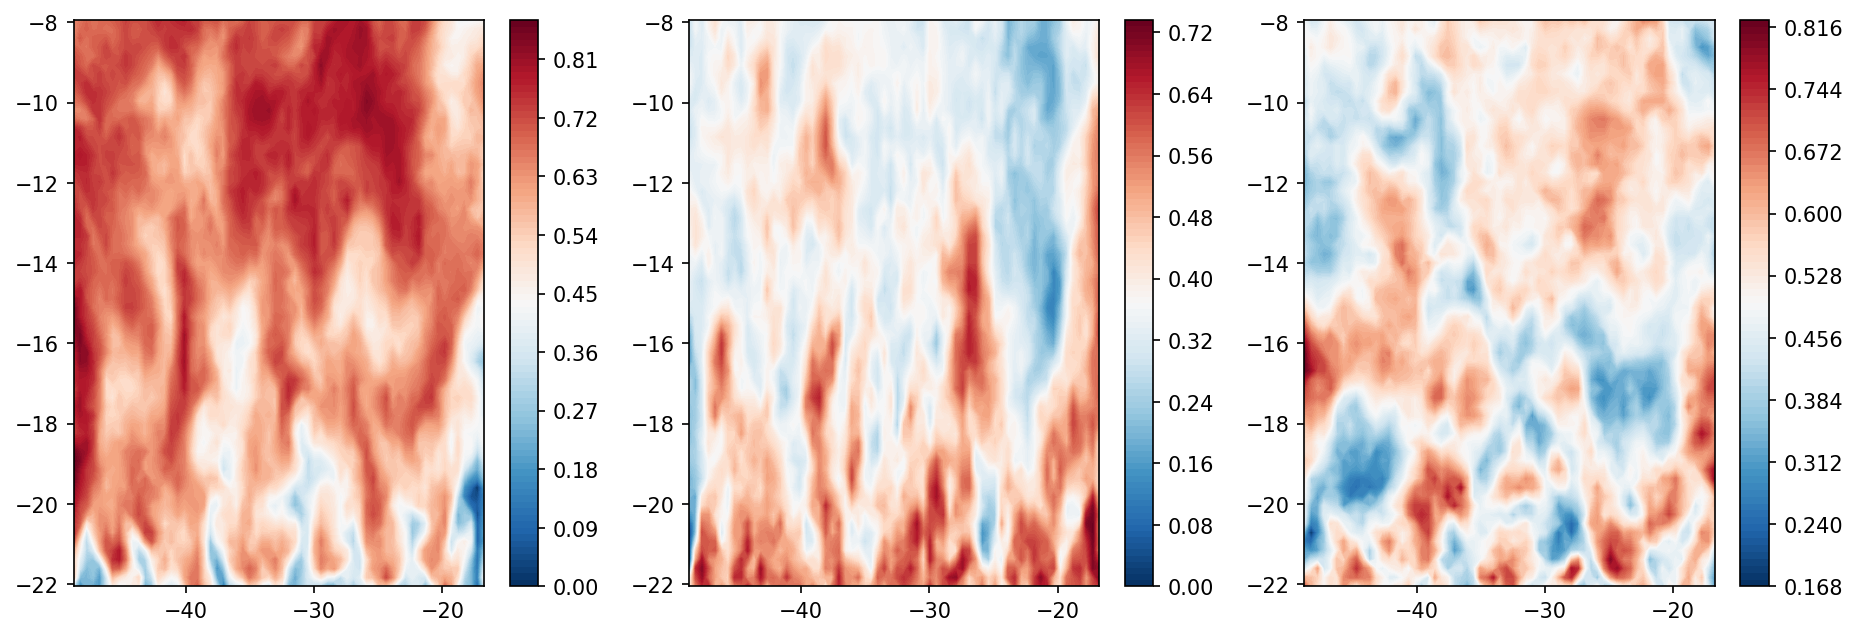

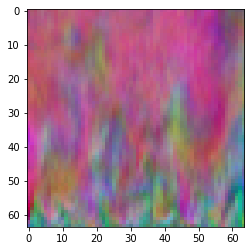

In [4]:
[yy,zz] = np.meshgrid(train_dataset.y,train_dataset.z)
def show_image(img, all_comps):
    
    cmapp='RdBu_r'
    npimg = img.numpy()

    if all_comps==False:
        fig, ax = plt.subplots(1, 1,figsize=(10, 5), dpi=150)
        c1=ax.contourf(zz,yy,np.transpose(npimg, (1, 2, 0))[:,:,0].T,np.linspace(0,1,100),cmap=cmapp)
        #c2=ax[1].contourf(zz,yy,np.transpose(npimg, (1, 2, 0))[:,:,1].T,levels=100,cmap=cmapp)
        #c3=ax[2].contourf(zz,yy,np.transpose(npimg, (1, 2, 0))[:,:,2].T,levels=100,cmap=cmapp)
        fig.colorbar(c1, ax=ax)
        plt.show()

        #fig, ax = plt.subplots(1, 1,figsize=(20, 10), dpi=150)
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()
        
    else:
        fig, ax = plt.subplots(1, 3,figsize=(15, 5), dpi=150)
        c1=ax[0].contourf(zz,yy,np.transpose(npimg, (1, 2, 0))[:,:,0].T,levels=100,cmap=cmapp)
        c2=ax[1].contourf(zz,yy,np.transpose(npimg, (1, 2, 0))[:,:,1].T,levels=100,cmap=cmapp)
        c3=ax[2].contourf(zz,yy,np.transpose(npimg, (1, 2, 0))[:,:,2].T,levels=100,cmap=cmapp)
        fig.colorbar(c1, ax=ax[0])
        fig.colorbar(c2, ax=ax[1])
        fig.colorbar(c3, ax=ax[2])

        plt.show()

        #fig, ax = plt.subplots(1, 1,figsize=(20, 10), dpi=150)
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()
        

show_image(train_dataset[0],all_comps)

In [5]:
train_data, val_data, test_data = random_split(train_dataset, [int(m*0.5), int(m*0.3), int(m*0.2)])
print(train_data[0].shape)

torch.Size([3, 64, 64])


In [6]:
batch_size=128

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=True)

i=0
for plane_batch in train_loader:
    i=i+1
    if i==2:
        break
print(plane_batch.size())

torch.Size([128, 3, 64, 64])


In [7]:
if all_comps == True:
    channels=3
else:
    channels=1

class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,channels=1):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            
            
            nn.Conv2d(channels, 256, 5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            
            nn.Conv2d(32, 8, 3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
        
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(8*8*8, 8*8*8),
            #nn.Linear(8*16*16, 8*16*16),
            nn.ReLU(True),
            nn.Linear(8*8*8, encoded_space_dim)
            #nn.Linear(8*16*16, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        #print(x.shape)
        x = self.flatten(x)
        #print(x.shape)
        x = self.encoder_lin(x)
        #print("===")
        #print(x.shape)
        
        return x


In [8]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,channels=1):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 8*8*8),
            #nn.Linear(encoded_space_dim, 8*16*16),
            nn.ReLU(True),
            nn.Linear(8*8*8, 8*8*8),
            #nn.Linear(8*16*16, 8*16*16),
        )
        
        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(8, 8, 8))
        #unflattened_size=(8, 16, 16))

        self.decoder_conv = nn.Sequential(
            
            nn.ConvTranspose2d(8, 32, 3, stride=1,padding=1, output_padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(32, 64, 3, stride=1,padding=1, output_padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            
            nn.ConvTranspose2d(64, 128, 3, stride=1,padding=1, output_padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            
            nn.ConvTranspose2d(128, 256, 3, stride=1,padding=1, output_padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2, mode='nearest'),

            nn.ConvTranspose2d(256, channels, 5, stride=1,padding=2, output_padding=0),
            nn.BatchNorm2d(channels),
            #nn.ReLU(True),
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        #print(x.shape)
        x = self.unflatten(x) 
        #print(x.shape)
        x = self.decoder_conv(x)
        #print("===")
        #print(x.shape)
        x = torch.sigmoid(x)
        
        return x
    
#nn.Upsample(scale_factor=2, mode='nearest')

In [9]:
#enc=Encoder(64,channels=channels)
#dec=Decoder(64,channels=channels)
#print(plane_batch.type('torch.FloatTensor').shape)
#print("===")
#x=enc(plane_batch.type('torch.FloatTensor'))
#print("===")
#x=dec(x)

In [10]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = int(8*16*16)

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,channels=channels)
decoder = Decoder(encoded_space_dim=d,channels=channels)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)


Selected device: cpu


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(8, 8, 8))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Upsample(scale_factor=2.0, mode=nearest)
    (7): ConvTranspose2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Upsample(scale_factor=2.0, mode=nearest)
    (11): 

In [11]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = (image_batch.type('torch.FloatTensor')).to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [12]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch in dataloader:
            # Move tensor to the proper device
            image_batch = (image_batch.type('torch.FloatTensor')).to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data


In [13]:
num_epochs = 30
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,
   train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   #plot_ae_outputs(encoder,decoder,n=10)

	 partial train loss (single batch): 0.065253
	 partial train loss (single batch): 0.047186
	 partial train loss (single batch): 0.033231
	 partial train loss (single batch): 0.028548
	 partial train loss (single batch): 0.025573
	 partial train loss (single batch): 0.024006
	 partial train loss (single batch): 0.023847
	 partial train loss (single batch): 0.023264
	 partial train loss (single batch): 0.022796
	 partial train loss (single batch): 0.022247
	 partial train loss (single batch): 0.022345
	 partial train loss (single batch): 0.022118
	 partial train loss (single batch): 0.021697
	 partial train loss (single batch): 0.021400
	 partial train loss (single batch): 0.021079
	 partial train loss (single batch): 0.020766
	 partial train loss (single batch): 0.020956
	 partial train loss (single batch): 0.020546
	 partial train loss (single batch): 0.020358
	 partial train loss (single batch): 0.019767
	 partial train loss (single batch): 0.019945
	 partial train loss (single batch

	 partial train loss (single batch): 0.015279
	 partial train loss (single batch): 0.015130
	 partial train loss (single batch): 0.015357

 EPOCH 2/30 	 train loss 0.016597626730799675 	 val loss 0.014308572746813297
	 partial train loss (single batch): 0.015123
	 partial train loss (single batch): 0.015041
	 partial train loss (single batch): 0.015056
	 partial train loss (single batch): 0.015273
	 partial train loss (single batch): 0.015026
	 partial train loss (single batch): 0.015282
	 partial train loss (single batch): 0.015050
	 partial train loss (single batch): 0.014938
	 partial train loss (single batch): 0.015126
	 partial train loss (single batch): 0.014800
	 partial train loss (single batch): 0.015036
	 partial train loss (single batch): 0.014877
	 partial train loss (single batch): 0.014874
	 partial train loss (single batch): 0.015134
	 partial train loss (single batch): 0.014679
	 partial train loss (single batch): 0.014819
	 partial train loss (single batch): 0.014833
	

	 partial train loss (single batch): 0.011921
	 partial train loss (single batch): 0.011761
	 partial train loss (single batch): 0.011760
	 partial train loss (single batch): 0.011756
	 partial train loss (single batch): 0.011931
	 partial train loss (single batch): 0.011826
	 partial train loss (single batch): 0.011578
	 partial train loss (single batch): 0.011968

 EPOCH 4/30 	 train loss 0.012887110002338886 	 val loss 0.011502929031848907
	 partial train loss (single batch): 0.025809
	 partial train loss (single batch): 0.015765
	 partial train loss (single batch): 0.015975
	 partial train loss (single batch): 0.016232
	 partial train loss (single batch): 0.016798
	 partial train loss (single batch): 0.015977
	 partial train loss (single batch): 0.015238
	 partial train loss (single batch): 0.015028
	 partial train loss (single batch): 0.014992
	 partial train loss (single batch): 0.014394
	 partial train loss (single batch): 0.015171
	 partial train loss (single batch): 0.014612
	

	 partial train loss (single batch): 0.011312
	 partial train loss (single batch): 0.011359
	 partial train loss (single batch): 0.011612
	 partial train loss (single batch): 0.011333
	 partial train loss (single batch): 0.011295
	 partial train loss (single batch): 0.011197
	 partial train loss (single batch): 0.011360
	 partial train loss (single batch): 0.011138
	 partial train loss (single batch): 0.011112
	 partial train loss (single batch): 0.011286
	 partial train loss (single batch): 0.011094
	 partial train loss (single batch): 0.010880
	 partial train loss (single batch): 0.011422

 EPOCH 6/30 	 train loss 0.011927284300327301 	 val loss 0.011078862473368645
	 partial train loss (single batch): 0.011499
	 partial train loss (single batch): 0.010947
	 partial train loss (single batch): 0.011366
	 partial train loss (single batch): 0.011482
	 partial train loss (single batch): 0.011292
	 partial train loss (single batch): 0.011715
	 partial train loss (single batch): 0.011316
	

	 partial train loss (single batch): 0.011460
	 partial train loss (single batch): 0.011721
	 partial train loss (single batch): 0.011698
	 partial train loss (single batch): 0.011908
	 partial train loss (single batch): 0.011908
	 partial train loss (single batch): 0.011902
	 partial train loss (single batch): 0.011982
	 partial train loss (single batch): 0.012406
	 partial train loss (single batch): 0.011950
	 partial train loss (single batch): 0.011867
	 partial train loss (single batch): 0.011646
	 partial train loss (single batch): 0.012062
	 partial train loss (single batch): 0.011420
	 partial train loss (single batch): 0.011448
	 partial train loss (single batch): 0.011589
	 partial train loss (single batch): 0.011022
	 partial train loss (single batch): 0.011087
	 partial train loss (single batch): 0.011808

 EPOCH 8/30 	 train loss 0.010828465223312378 	 val loss 0.011884205043315887
	 partial train loss (single batch): 0.010962
	 partial train loss (single batch): 0.010994
	

	 partial train loss (single batch): 0.010524
	 partial train loss (single batch): 0.011535
	 partial train loss (single batch): 0.011674
	 partial train loss (single batch): 0.012186
	 partial train loss (single batch): 0.012027
	 partial train loss (single batch): 0.011229
	 partial train loss (single batch): 0.011260
	 partial train loss (single batch): 0.011360
	 partial train loss (single batch): 0.011310
	 partial train loss (single batch): 0.011011
	 partial train loss (single batch): 0.011059
	 partial train loss (single batch): 0.010969
	 partial train loss (single batch): 0.011321
	 partial train loss (single batch): 0.011023
	 partial train loss (single batch): 0.010936
	 partial train loss (single batch): 0.010639
	 partial train loss (single batch): 0.010947
	 partial train loss (single batch): 0.010637
	 partial train loss (single batch): 0.010541
	 partial train loss (single batch): 0.010756
	 partial train loss (single batch): 0.010460
	 partial train loss (single batch

	 partial train loss (single batch): 0.010290
	 partial train loss (single batch): 0.010089
	 partial train loss (single batch): 0.010257
	 partial train loss (single batch): 0.010310
	 partial train loss (single batch): 0.009988
	 partial train loss (single batch): 0.010054
	 partial train loss (single batch): 0.010370
	 partial train loss (single batch): 0.009950
	 partial train loss (single batch): 0.010292
	 partial train loss (single batch): 0.010206
	 partial train loss (single batch): 0.009773
	 partial train loss (single batch): 0.009918
	 partial train loss (single batch): 0.010011
	 partial train loss (single batch): 0.009808
	 partial train loss (single batch): 0.009847
	 partial train loss (single batch): 0.010021
	 partial train loss (single batch): 0.009994
	 partial train loss (single batch): 0.010247
	 partial train loss (single batch): 0.009903
	 partial train loss (single batch): 0.009970
	 partial train loss (single batch): 0.009994
	 partial train loss (single batch

	 partial train loss (single batch): 0.009436
	 partial train loss (single batch): 0.009533
	 partial train loss (single batch): 0.009685
	 partial train loss (single batch): 0.009360
	 partial train loss (single batch): 0.009429
	 partial train loss (single batch): 0.009463
	 partial train loss (single batch): 0.009347
	 partial train loss (single batch): 0.009572
	 partial train loss (single batch): 0.009509
	 partial train loss (single batch): 0.009203
	 partial train loss (single batch): 0.009272
	 partial train loss (single batch): 0.009621
	 partial train loss (single batch): 0.009209
	 partial train loss (single batch): 0.009610
	 partial train loss (single batch): 0.009579
	 partial train loss (single batch): 0.009247
	 partial train loss (single batch): 0.009270
	 partial train loss (single batch): 0.009382
	 partial train loss (single batch): 0.009241
	 partial train loss (single batch): 0.009306
	 partial train loss (single batch): 0.009436
	 partial train loss (single batch

	 partial train loss (single batch): 0.009348
	 partial train loss (single batch): 0.009536
	 partial train loss (single batch): 0.009266
	 partial train loss (single batch): 0.008912
	 partial train loss (single batch): 0.008894
	 partial train loss (single batch): 0.009031
	 partial train loss (single batch): 0.009168
	 partial train loss (single batch): 0.009243
	 partial train loss (single batch): 0.008997
	 partial train loss (single batch): 0.009018
	 partial train loss (single batch): 0.009071
	 partial train loss (single batch): 0.008994
	 partial train loss (single batch): 0.009177
	 partial train loss (single batch): 0.009146
	 partial train loss (single batch): 0.009428
	 partial train loss (single batch): 0.009873
	 partial train loss (single batch): 0.010485
	 partial train loss (single batch): 0.010346
	 partial train loss (single batch): 0.011010
	 partial train loss (single batch): 0.011368
	 partial train loss (single batch): 0.010956
	 partial train loss (single batch

	 partial train loss (single batch): 0.010672
	 partial train loss (single batch): 0.010360
	 partial train loss (single batch): 0.010331
	 partial train loss (single batch): 0.010083
	 partial train loss (single batch): 0.010436
	 partial train loss (single batch): 0.010143
	 partial train loss (single batch): 0.010410
	 partial train loss (single batch): 0.010128
	 partial train loss (single batch): 0.009684
	 partial train loss (single batch): 0.009717
	 partial train loss (single batch): 0.009678
	 partial train loss (single batch): 0.010044
	 partial train loss (single batch): 0.009999
	 partial train loss (single batch): 0.009724
	 partial train loss (single batch): 0.009626
	 partial train loss (single batch): 0.009784
	 partial train loss (single batch): 0.009675
	 partial train loss (single batch): 0.009768
	 partial train loss (single batch): 0.009780
	 partial train loss (single batch): 0.009300
	 partial train loss (single batch): 0.009518
	 partial train loss (single batch

	 partial train loss (single batch): 0.009007
	 partial train loss (single batch): 0.008776
	 partial train loss (single batch): 0.008952
	 partial train loss (single batch): 0.009077
	 partial train loss (single batch): 0.009219
	 partial train loss (single batch): 0.009048
	 partial train loss (single batch): 0.008999
	 partial train loss (single batch): 0.008984
	 partial train loss (single batch): 0.008895
	 partial train loss (single batch): 0.009107
	 partial train loss (single batch): 0.009064
	 partial train loss (single batch): 0.009198
	 partial train loss (single batch): 0.008981
	 partial train loss (single batch): 0.008813
	 partial train loss (single batch): 0.008732
	 partial train loss (single batch): 0.008841
	 partial train loss (single batch): 0.009610
	 partial train loss (single batch): 0.009138
	 partial train loss (single batch): 0.009079
	 partial train loss (single batch): 0.008987
	 partial train loss (single batch): 0.009096
	 partial train loss (single batch

	 partial train loss (single batch): 0.008739
	 partial train loss (single batch): 0.008571
	 partial train loss (single batch): 0.008804
	 partial train loss (single batch): 0.008515
	 partial train loss (single batch): 0.008716
	 partial train loss (single batch): 0.008589
	 partial train loss (single batch): 0.008386
	 partial train loss (single batch): 0.008542
	 partial train loss (single batch): 0.008736
	 partial train loss (single batch): 0.008851
	 partial train loss (single batch): 0.008731
	 partial train loss (single batch): 0.008579
	 partial train loss (single batch): 0.008575
	 partial train loss (single batch): 0.008545
	 partial train loss (single batch): 0.008752
	 partial train loss (single batch): 0.008684
	 partial train loss (single batch): 0.008874
	 partial train loss (single batch): 0.008595
	 partial train loss (single batch): 0.008430
	 partial train loss (single batch): 0.008392
	 partial train loss (single batch): 0.008511
	 partial train loss (single batch

	 partial train loss (single batch): 0.008174
	 partial train loss (single batch): 0.008483
	 partial train loss (single batch): 0.008702
	 partial train loss (single batch): 0.008315
	 partial train loss (single batch): 0.008327
	 partial train loss (single batch): 0.008540
	 partial train loss (single batch): 0.008376
	 partial train loss (single batch): 0.008566
	 partial train loss (single batch): 0.008339
	 partial train loss (single batch): 0.008505
	 partial train loss (single batch): 0.008356
	 partial train loss (single batch): 0.008220
	 partial train loss (single batch): 0.008309
	 partial train loss (single batch): 0.008521
	 partial train loss (single batch): 0.008624
	 partial train loss (single batch): 0.008543
	 partial train loss (single batch): 0.008437
	 partial train loss (single batch): 0.008384
	 partial train loss (single batch): 0.008344
	 partial train loss (single batch): 0.008652
	 partial train loss (single batch): 0.008458
	 partial train loss (single batch

	 partial train loss (single batch): 0.013228
	 partial train loss (single batch): 0.013061
	 partial train loss (single batch): 0.012834
	 partial train loss (single batch): 0.012809
	 partial train loss (single batch): 0.013073
	 partial train loss (single batch): 0.012510
	 partial train loss (single batch): 0.012797
	 partial train loss (single batch): 0.013224
	 partial train loss (single batch): 0.012486
	 partial train loss (single batch): 0.012518
	 partial train loss (single batch): 0.013123
	 partial train loss (single batch): 0.012732
	 partial train loss (single batch): 0.013087
	 partial train loss (single batch): 0.012621
	 partial train loss (single batch): 0.012927
	 partial train loss (single batch): 0.012604
	 partial train loss (single batch): 0.012370
	 partial train loss (single batch): 0.012696
	 partial train loss (single batch): 0.012917
	 partial train loss (single batch): 0.012887
	 partial train loss (single batch): 0.012786
	 partial train loss (single batch

	 partial train loss (single batch): 0.011102
	 partial train loss (single batch): 0.011331
	 partial train loss (single batch): 0.010752
	 partial train loss (single batch): 0.010986
	 partial train loss (single batch): 0.011044
	 partial train loss (single batch): 0.011242
	 partial train loss (single batch): 0.011100
	 partial train loss (single batch): 0.010778
	 partial train loss (single batch): 0.010608
	 partial train loss (single batch): 0.010864
	 partial train loss (single batch): 0.010520
	 partial train loss (single batch): 0.010832
	 partial train loss (single batch): 0.011022
	 partial train loss (single batch): 0.010556
	 partial train loss (single batch): 0.010510
	 partial train loss (single batch): 0.010810
	 partial train loss (single batch): 0.010554
	 partial train loss (single batch): 0.010845
	 partial train loss (single batch): 0.010462
	 partial train loss (single batch): 0.010564
	 partial train loss (single batch): 0.010416
	 partial train loss (single batch

	 partial train loss (single batch): 0.009505
	 partial train loss (single batch): 0.009719
	 partial train loss (single batch): 0.009301
	 partial train loss (single batch): 0.009478
	 partial train loss (single batch): 0.009828
	 partial train loss (single batch): 0.009323
	 partial train loss (single batch): 0.009564
	 partial train loss (single batch): 0.009162
	 partial train loss (single batch): 0.009353
	 partial train loss (single batch): 0.009452
	 partial train loss (single batch): 0.009743
	 partial train loss (single batch): 0.009544
	 partial train loss (single batch): 0.009229
	 partial train loss (single batch): 0.009370
	 partial train loss (single batch): 0.009480
	 partial train loss (single batch): 0.009209
	 partial train loss (single batch): 0.009485
	 partial train loss (single batch): 0.009676
	 partial train loss (single batch): 0.009380
	 partial train loss (single batch): 0.009318
	 partial train loss (single batch): 0.009615
	 partial train loss (single batch

In [14]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()

0.009831434115767479

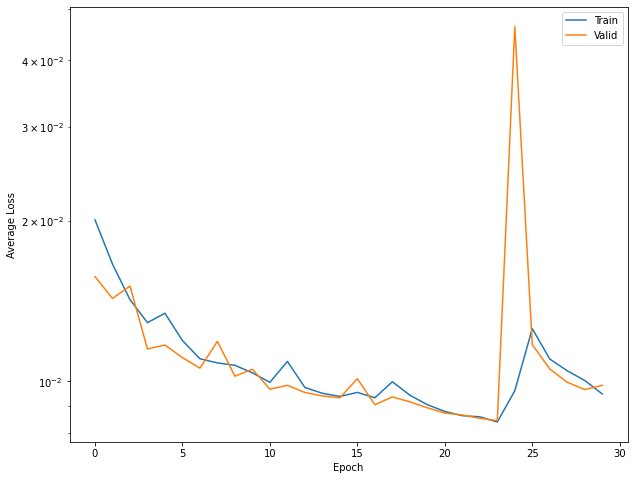

In [15]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

# evaluate

In [16]:
encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    images = next(iter(test_loader))
    images = (images.type('torch.FloatTensor')).to(device)
    latent = encoder(images)
    latent = latent.cpu()

## Generate new samples from the random latent code
To generate new images from the latent code, we sample randomly from a normal distribution with the mean and standard deviation of the encoded data. These samples will be passed to the decoder, which will create the reconstructed images.



In [17]:
#def show_image(img):
#    npimg = img.numpy()
#    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    images = next(iter(test_loader))
    images_cpu=images.cpu()
    images = (images.type('torch.FloatTensor')).to(device)
    latent = encoder(images)
    latent_cpu = latent.cpu()
   

    latent_mode= latent.clone().detach()
    latent_mode=latent_mode.cpu()

     
    print(latent_mode.shape)
    print(latent_cpu.shape)

    mode=[0]
    
    for i in range(0,batch_size):
        for j in range(0,d):
            if j not in mode:
                latent_mode[i][j]=0
                
    latent_mode = latent_mode.to(device)
    
    img_recon = decoder(latent)
    img_recon_cpu = img_recon.cpu()
    
    mode_recon = decoder(latent_mode)
    mode_recon_cpu = mode_recon.cpu()
    
    
    print(img_recon_cpu[0].shape)

torch.Size([128, 2048])
torch.Size([128, 2048])
torch.Size([3, 64, 64])


In [18]:
print(latent_mode[41,:])

tensor([-0.0689,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000])


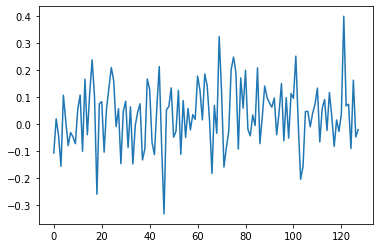

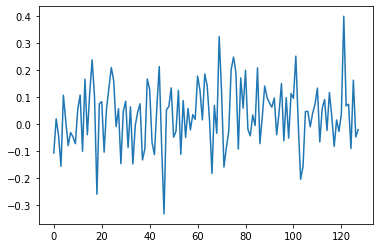

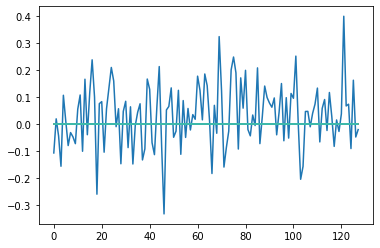

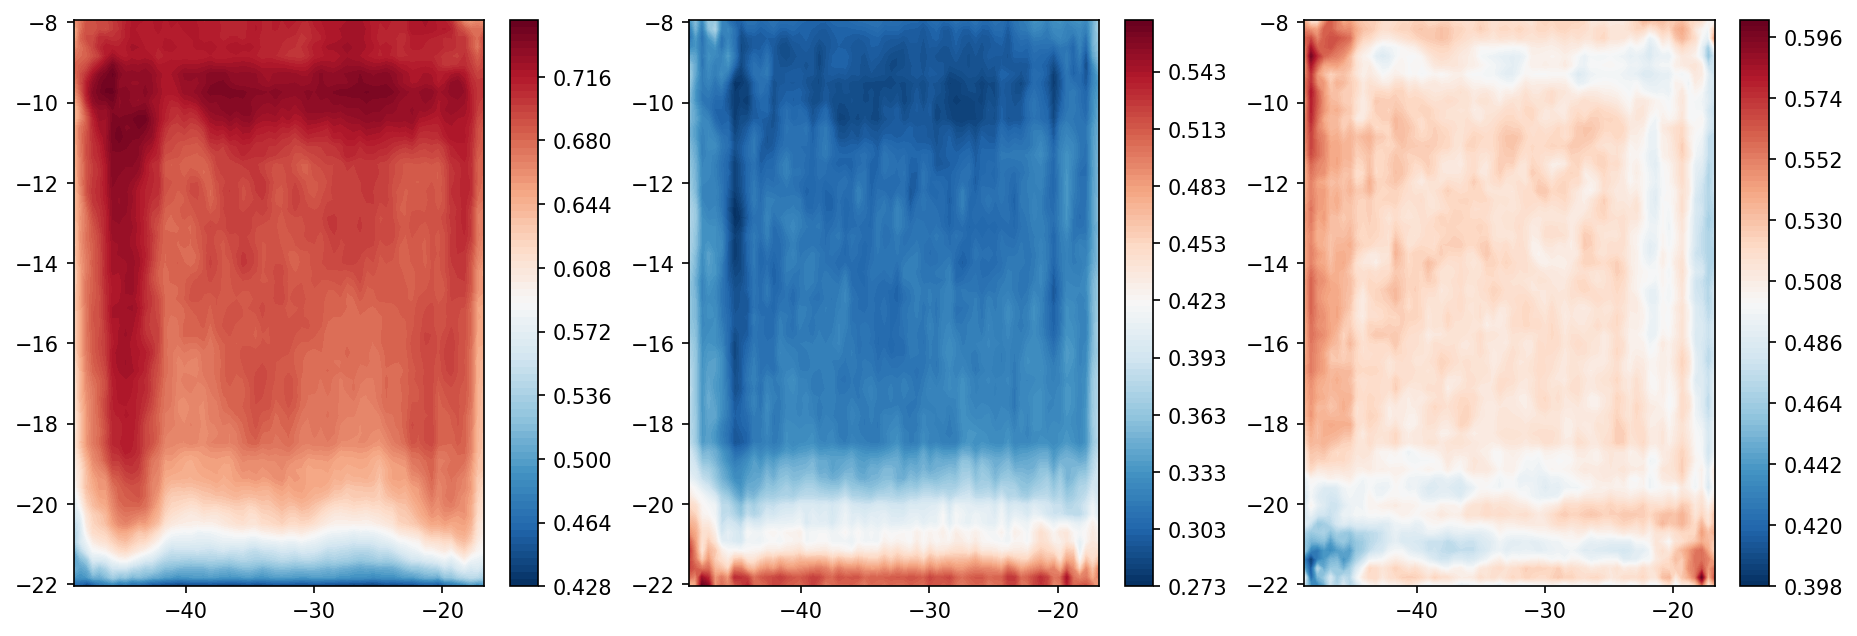

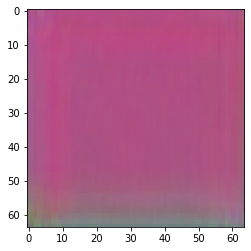

In [19]:
plt.plot(latent_cpu.numpy()[:,mode[0]])
plt.show()

plt.plot(latent_mode.numpy()[:,mode[0]])
plt.show()

plt.plot(latent_mode.numpy()[:,0:40:1])
plt.show()


show_image(mode_recon_cpu[0],all_comps)

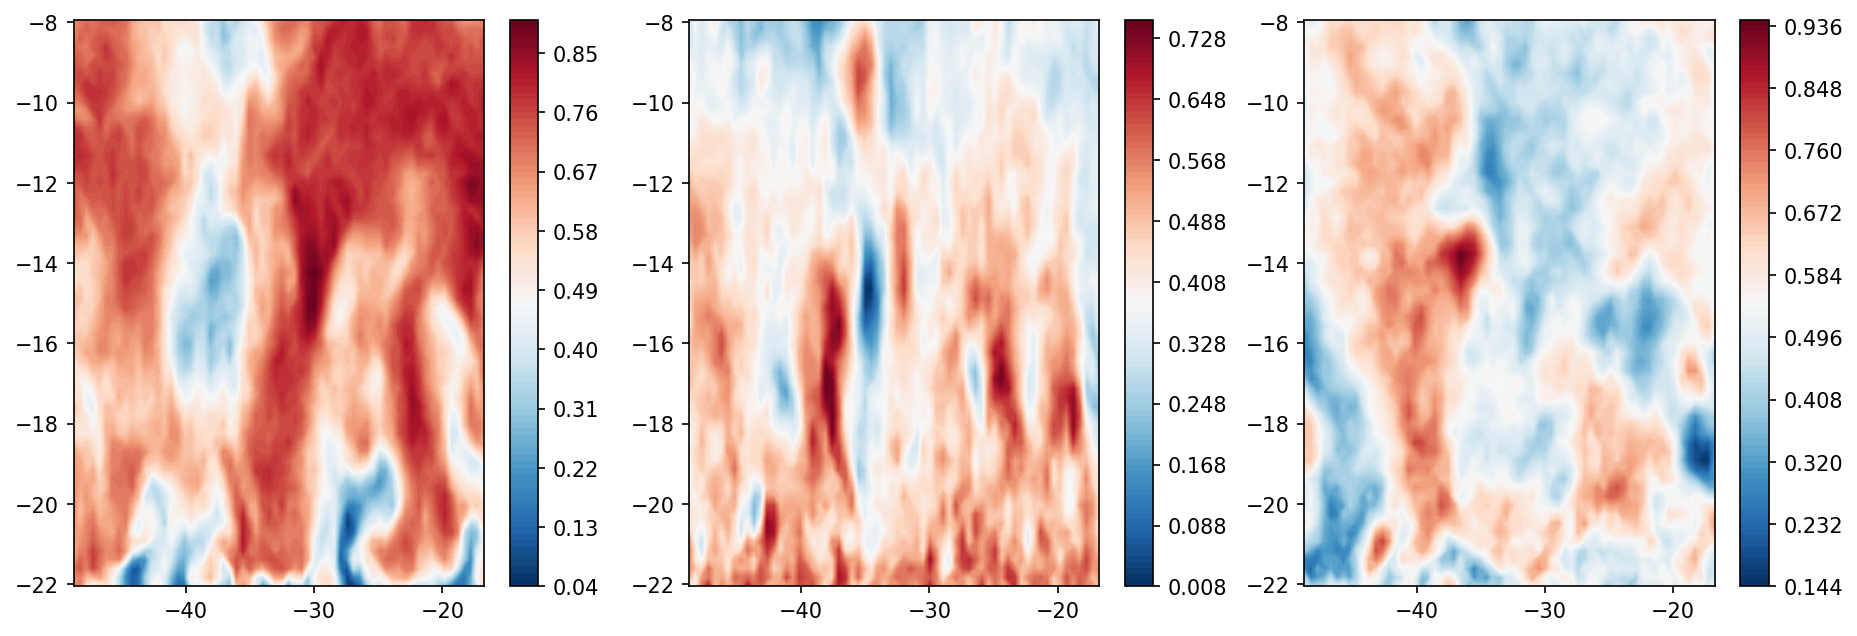

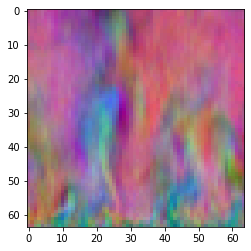

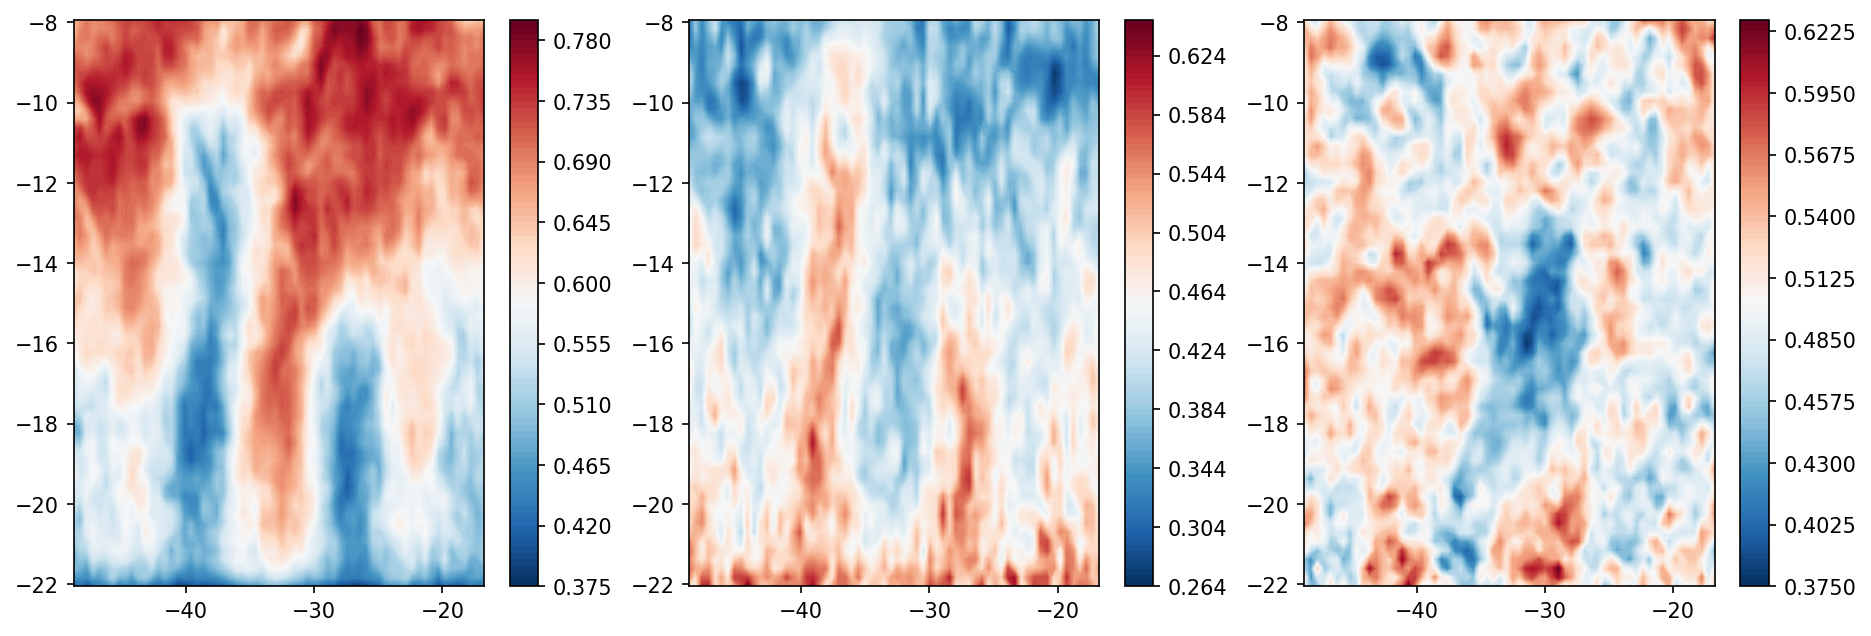

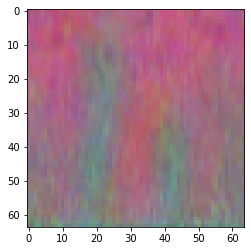

In [20]:
kk=10
show_image(images_cpu[kk],all_comps)
show_image(img_recon_cpu[kk],all_comps)

In [21]:
sys.exit(0)

SystemExit: 0

/scratch/adperez/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Visualize the latent space with t-SNE
After we can observe dynamic visualization to see the latent space learned by the autoencoder. First, we create the encoded samples using the test set.

In [ ]:

encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(32*8*8, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        #print(x.shape)
        x = self.flatten(x)
        #print(x.shape)
        x = self.encoder_lin(x)
        #print(x.shape)
        
        return x
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 32*8*8),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 8, 8))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2,padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        #print(x.shape)
        x = self.unflatten(x) 
        #print(x.shape)
        x = self.decoder_conv(x)
        #print(x.shape)
        x = torch.sigmoid(x)
        return x